In [2]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

### 使用三阶多项式生成训练和测试数据的标签
### 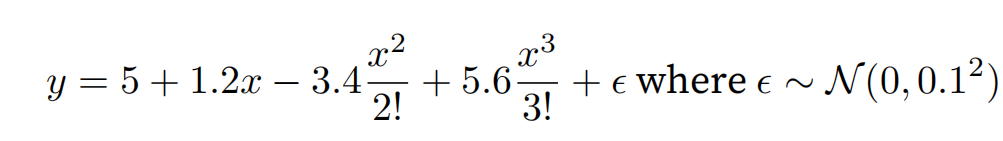
### np.random.normal为随机生成正态分布数
### np.power(a,b)为计算a的b次方，这一行实现的就是生成计算式每一自变量项
### np.arange(max_degree).reshape(1, -1)实现生成从[0,20)的尺寸为（1，20）的张量
### scale表示标准差，默认为1；true_w表示上述公式的系数

In [3]:
max_degree = 20 # 多项式的最⼤阶数
n_train, n_test = 100, 100 # 训练和测试数据集⼤⼩
true_w = np.zeros(max_degree) # 分配⼤量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6]) # 其他的全是0

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1) # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [4]:
g = np.random.normal(size=(2, 1)) 
n = np.arange(3).reshape(1,-1)
np.power(g,n).shape, n, g

((2, 3),
 array([[0, 1, 2]]),
 array([[ 0.51155074],
        [-0.37491309]]))

### poly_features为（200，20）的向量，每一列表示对应元素的对应次方，如位置1，3表示features中的第二个数的三次方
### for循环表示对应的n次方项除n！最终得到的每一行对应的是X^o,X^1,(X^2)/2!,(X^3)/3!...
### 此时ploy为(200,20),每一行为以上的内容
### np.dot表示两个向量内积，(200,20)与(20)的内积，得到的是每一行分别与true_w内积的结果，内积后即完成了上述多项式的表达，最后再加上一个噪声。即得到y的值用labels表示

In [5]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

### [:2]表示从头取到前两行，与[0:2]等价

In [14]:
features.shape, features[:2], poly_features[:2, :], labels[:2], labels.shape

(torch.Size([200, 1]),
 tensor([[0.1062],
         [0.2925]]),
 tensor([[1.0000e+00, 1.0621e-01, 5.6401e-03, 1.9967e-04, 5.3017e-06, 1.1262e-07,
          1.9935e-09, 3.0246e-11, 4.0155e-13, 4.7386e-15, 5.0328e-17, 4.8593e-19,
          4.3008e-21, 3.5137e-23, 2.6656e-25, 1.8874e-27, 1.2528e-29, 7.8271e-32,
          4.6183e-34, 2.5816e-36],
         [1.0000e+00, 2.9249e-01, 4.2774e-02, 4.1703e-03, 3.0494e-04, 1.7838e-05,
          8.6957e-07, 3.6334e-08, 1.3284e-09, 4.3171e-11, 1.2627e-12, 3.3575e-14,
          8.1835e-16, 1.8412e-17, 3.8466e-19, 7.5006e-21, 1.3711e-22, 2.3591e-24,
          3.8333e-26, 5.9010e-28]]),
 tensor([5.2388, 5.1748]),
 torch.Size([200]))

In [15]:
def evaluate_loss(net, data_iter, loss): #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2) # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [36]:
def train(train_features, test_features, train_labels, test_labels,
        num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                                batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                        evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

In [37]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
        labels[:n_train], labels[n_train:])

weight: [[ 5.0042167  1.1973338 -3.4263363  5.6405015]]


### 让他显示数值的

In [34]:
def train(train_features, test_features, train_labels, test_labels,
        num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                                batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)

    for epoch in range(num_epochs):
        train_metrics = d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            print(f'训练损失{train_metrics[0]:.5f},测试损失{evaluate_loss(net, test_iter, loss):.5f}')
            # animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
            #             evaluate_loss(net, test_iter, loss)))
    # print('weight:', net[0].weight.data.numpy())

### 欠拟合

In [35]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
        labels[:n_train], labels[n_train:])

训练损失25.93238,测试损失26.20157
训练损失6.56936,测试损失10.34951
训练损失6.60257,测试损失10.33659
训练损失6.54701,测试损失10.34177
训练损失6.55959,测试损失10.33881
训练损失6.55519,测试损失10.33973
训练损失6.55543,测试损失10.33485
训练损失6.57955,测试损失10.33817
训练损失6.62973,测试损失10.34429
训练损失6.56605,测试损失10.33121
训练损失6.53858,测试损失10.34148
训练损失6.54970,测试损失10.34914
训练损失6.55261,测试损失10.35024
训练损失6.54297,测试损失10.33334
训练损失6.56661,测试损失10.33290
训练损失6.53187,测试损失10.33695
训练损失6.54203,测试损失10.34275
训练损失6.56267,测试损失10.32781
训练损失6.56698,测试损失10.34106
训练损失6.55424,测试损失10.33694
训练损失6.55785,测试损失10.34030


### 过拟合

In [38]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
        labels[:n_train], labels[n_train:], num_epochs=1500)

weight: [[ 4.976848    1.263148   -3.2653513   5.1880183  -0.5796958   1.4991105
   0.15383871  0.12010279  0.06954651 -0.03272804  0.1166203  -0.18874793
   0.03860768  0.18788746 -0.04239256  0.11517595  0.21226598 -0.16639413
  -0.10470539  0.1313476 ]]
